In [ ]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# EuroSAT 위성 사진 데이터셋
DATA_DIR = 'dataset/'
(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir=DATA_DIR)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling dataset/eurosat/rgb/2.0.0.incompleteY417V4/eurosat-train.tfrecord*...:   0%|          | 0/27000 [00:…

Dataset eurosat downloaded and prepared to dataset/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
print(train_ds)
print(valid_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path='dataset/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('

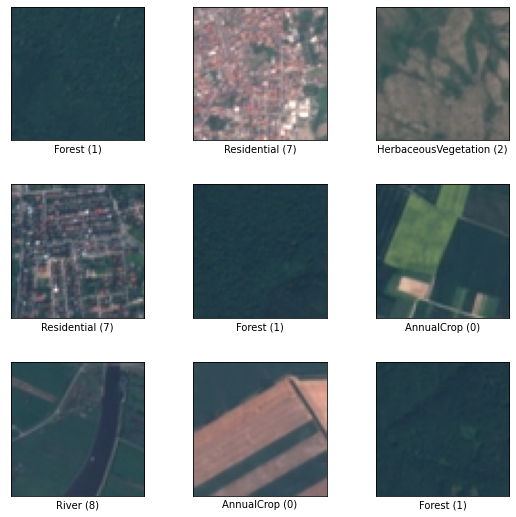

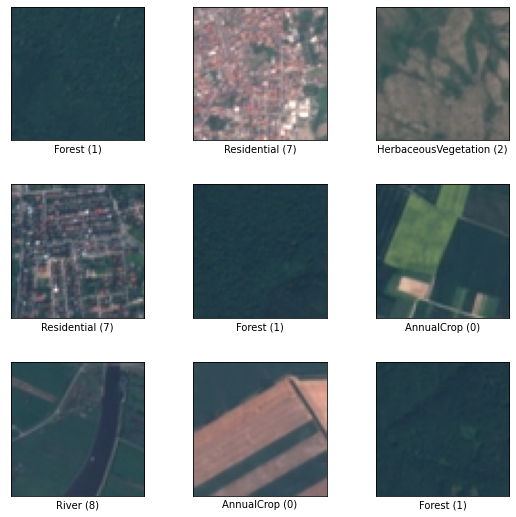

In [ ]:
# 데이터 확인
tfds.show_examples(train_ds, info)

,image,label
0,,5 (Pasture)
1,,7 (Residential)
2,,0 (AnnualCrop)
3,,1 (Forest)
4,,0 (AnnualCrop)
5,,2 (HerbaceousVegetation)
6,,9 (SeaLake)
7,,8 (River)
8,,2 (HerbaceousVegetation)
9,,9 (SeaLake)

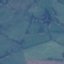
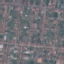
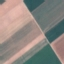
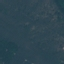
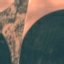
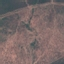
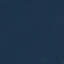
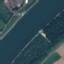
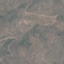
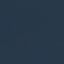

In [ ]:
tfds.as_dataframe(valid_ds.take(10), info)

In [ ]:
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


In [ ]:
# 숫자 레이블 활용 -> 문자열 메타데이터
print(info.features['label'].int2str(6))

PermanentCrop


In [ ]:
# 데이터 전처리
BATCH_SIZE = 64
BUFFER_SIZE = 1000

def preprocess_data(image, label):
  image = tf.cast(image, tf.float32) / 255.
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# build model
def build_model():
  model = tf.keras.Sequential([
      #Convolution
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      #Classifier
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])
  return model

In [ ]:
model = build_model()

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=50)

Epoch 1/50
338/338 [==============================] - 172s 503ms/step - loss: 1.5853 - accuracy: 0.4461 - val_loss: 1.6621 - val_accuracy: 0.4687
Epoch 2/50
338/338 [==============================] - 167s 494ms/step - loss: 1.1871 - accuracy: 0.5870 - val_loss: 0.8876 - val_accuracy: 0.7000
Epoch 3/50
338/338 [==============================] - 167s 493ms/step - loss: 0.9890 - accuracy: 0.6588 - val_loss: 0.7733 - val_accuracy: 0.7256
Epoch 4/50
338/338 [==============================] - 166s 490ms/step - loss: 0.8926 - accuracy: 0.6956 - val_loss: 0.6831 - val_accuracy: 0.7700
Epoch 5/50
338/338 [==============================] - 166s 492ms/step - loss: 0.7945 - accuracy: 0.7295 - val_loss: 0.6126 - val_accuracy: 0.7937
Epoch 6/50
338/338 [==============================] - 165s 489ms/step - loss: 0.7128 - accuracy: 0.7551 - val_loss: 0.5658 - val_accuracy: 0.8133
Epoch 7/50
338/338 [==============================] - 165s 487ms/step - loss: 0.6525 - accuracy: 0.7790 - val_loss: 0.5343 -

In [ ]:
def plot_loss_acc(history, epoch):
  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
  fig, axes = plt.subplots(1,2, figsize=(12, 4))

  axes[0].plot(range(1, epoch + 1), loss, label='Training')
  axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
  axes[0].legend(loc='best')
  axes[0].set_title('Loss')

  axes[1].plot(range(1, epoch + 1), acc, label='Training')
  axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

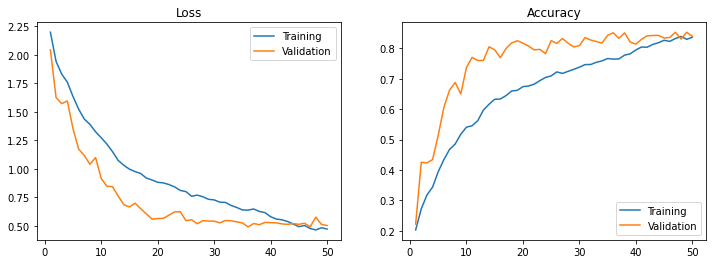

In [ ]:
plot_loss_acc(history, 50)

# 데이터 증강 (Data Augmentation)

In [ ]:
image_batch, label_batch = next(iter(train_data.take(1)))

In [ ]:
type(image_batch)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
image_batch.shape

TensorShape([64, 64, 64, 3])

In [ ]:
type(label_batch[0]), label_batch[0].numpy()

(tensorflow.python.framework.ops.EagerTensor, 7)

(64, 64, 3)


Text(0.5, 1.0, 'Pasture')

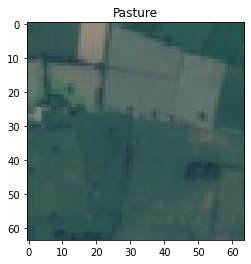

In [ ]:
image = image_batch[15]
print(image.shape)
label = label_batch[15].numpy()
plt.imshow(image)
plt.title(info.features['label'].int2str(label))

In [ ]:
# 데이터 증강 전후를 비교하는 시각화 함수
def plot_augmentation(original, augmented):
  fig, axes = plt.subplots(1, 2, figsize=(12, 4))
  axes[0].imshow(original)
  axes[0].set_title('Original')
  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')
  plt.show()

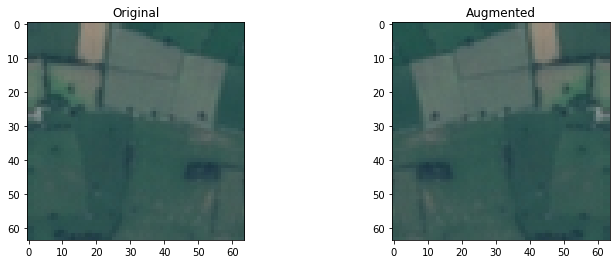

In [ ]:
# 좌우 뒤집기
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

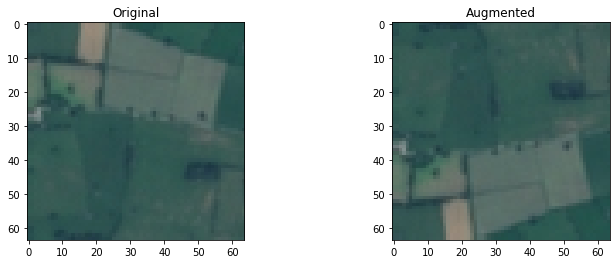

In [ ]:
# 상하 뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

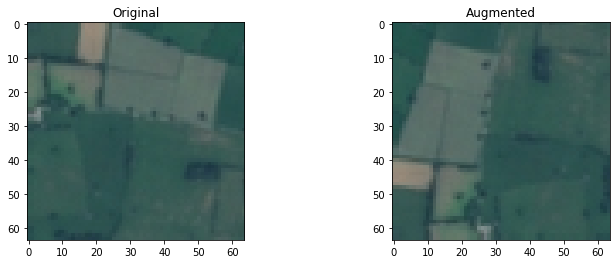

In [ ]:
# 회전
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

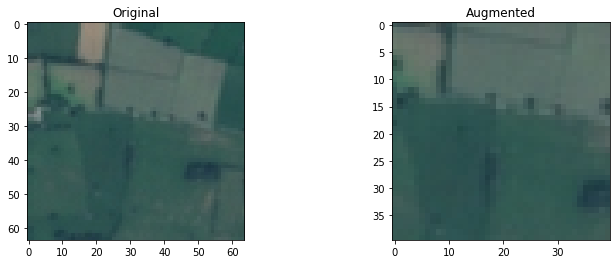

In [ ]:
# 이미지 자르기 1
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

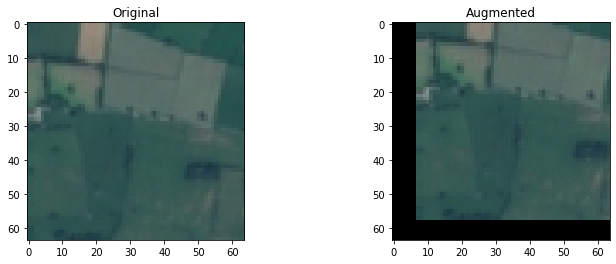

In [ ]:
# 이미지 자르기 2
img = tf.image.resize_with_crop_or_pad(image, 64 + 20, 64 + 20)
crop2 = tf.image.random_crop(img, size=[64,64,3])
plot_augmentation(image, crop2)

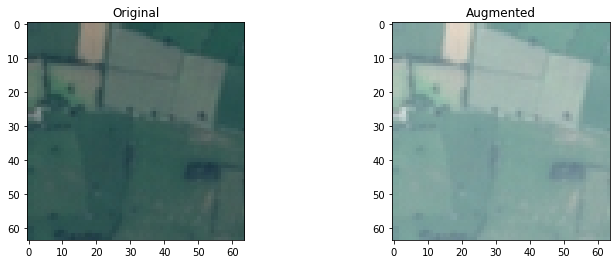

In [ ]:
# 이미지 밝기
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

In [ ]:
# 이미지 채도(saturation), 대비(contrast)

In [ ]:
# 이미지 증강 전처리 함수
def data_augmentation(image, label):
  # 좌우반전
  image = tf.image.random_flip_left_right(image) 
  # 상하반전
  image = tf.image.random_flip_up_down(image)
  # 발기
  image = tf.image.random_brightness(image, max_delta=0.3)
  # 크롭 (줌)
  image = tf.image.random_crop(image, size=[64, 64, 3])

  # 정규화
  image = tf.cast(image, tf.float32) / 255.

  return image, label

In [ ]:
train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
aug_model = build_model()
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
aug_history = aug_model.fit(train_aug,
                            validation_data=valid_aug,
                            epochs=50)

Epoch 1/50
338/338 [==============================] - 7s 18ms/step - loss: 1.9540 - accuracy: 0.2671 - val_loss: 1.9251 - val_accuracy: 0.3035
Epoch 2/50
338/338 [==============================] - 5s 16ms/step - loss: 1.6545 - accuracy: 0.3432 - val_loss: 1.4338 - val_accuracy: 0.4683
Epoch 3/50
338/338 [==============================] - 6s 18ms/step - loss: 1.5154 - accuracy: 0.4087 - val_loss: 1.2064 - val_accuracy: 0.5259
Epoch 4/50
338/338 [==============================] - 6s 17ms/step - loss: 1.4060 - accuracy: 0.4563 - val_loss: 1.0944 - val_accuracy: 0.5757
Epoch 5/50
338/338 [==============================] - 5s 15ms/step - loss: 1.3414 - accuracy: 0.4871 - val_loss: 1.1313 - val_accuracy: 0.5600
Epoch 6/50
338/338 [==============================] - 5s 15ms/step - loss: 1.2680 - accuracy: 0.5215 - val_loss: 1.0170 - val_accuracy: 0.6074
Epoch 7/50
338/338 [==============================] - 5s 16ms/step - loss: 1.2147 - accuracy: 0.5458 - val_loss: 1.0023 - val_accuracy: 0.6219

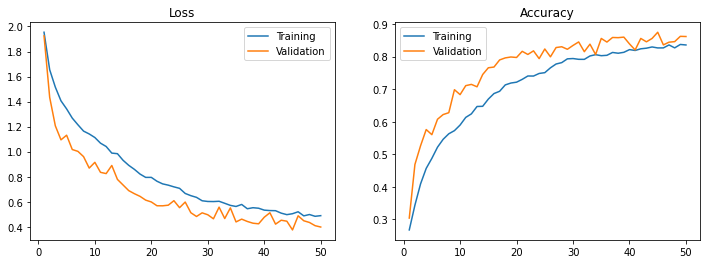

In [59]:
plot_loss_acc(aug_history, 50)

In [60]:
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                              weights='imagenet',
                              input_shape=[64,64,3])

94683136/94668760 [==============================] - 1s 0us/step


In [61]:
pre_trained_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [62]:
# 사전 학습된 가중치를 업데이트 되지 않도록 설정
pre_trained_base.trainable = False

In [63]:
pre_trained_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [64]:
# from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import plot_model

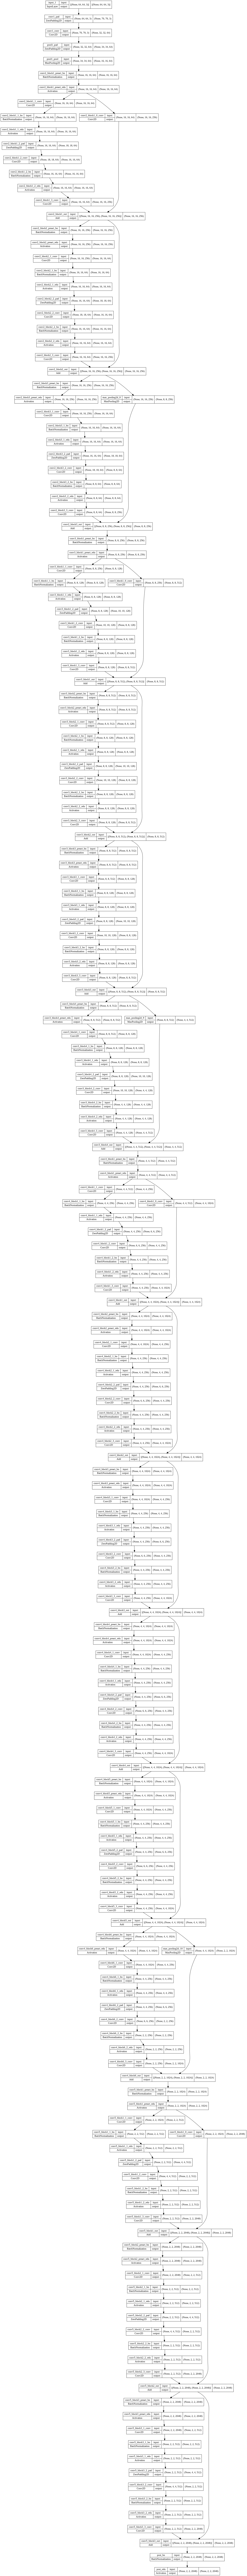

In [66]:
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50v2.png')

In [67]:
# 분류 풀리컨넥티드 레이어 작성
def build_trainsfer_classifier():
  model = tf.keras.Sequential([
      # Pre-trained Base
      pre_trained_base,
      # Classifer 레이어
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])
  return model

tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               1048704   
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 10)               

In [68]:
tc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [69]:
tc_history = tc_model.fit(train_aug,
                          validation_data=valid_aug,
                          epochs=50)

Epoch 1/50
338/338 [==============================] - 14s 30ms/step - loss: 1.0829 - accuracy: 0.6556 - val_loss: 0.6130 - val_accuracy: 0.8028
Epoch 2/50
338/338 [==============================] - 9s 27ms/step - loss: 0.7621 - accuracy: 0.7611 - val_loss: 0.5359 - val_accuracy: 0.8248
Epoch 3/50
338/338 [==============================] - 9s 27ms/step - loss: 0.6576 - accuracy: 0.7897 - val_loss: 0.5025 - val_accuracy: 0.8346
Epoch 4/50
338/338 [==============================] - 9s 27ms/step - loss: 0.6054 - accuracy: 0.8051 - val_loss: 0.4704 - val_accuracy: 0.8435
Epoch 5/50
338/338 [==============================] - 11s 32ms/step - loss: 0.5633 - accuracy: 0.8193 - val_loss: 0.4621 - val_accuracy: 0.8433
Epoch 6/50
338/338 [==============================] - 9s 28ms/step - loss: 0.5549 - accuracy: 0.8206 - val_loss: 0.4599 - val_accuracy: 0.8456
Epoch 7/50
338/338 [==============================] - 10s 27ms/step - loss: 0.5323 - accuracy: 0.8272 - val_loss: 0.4541 - val_accuracy: 0.8

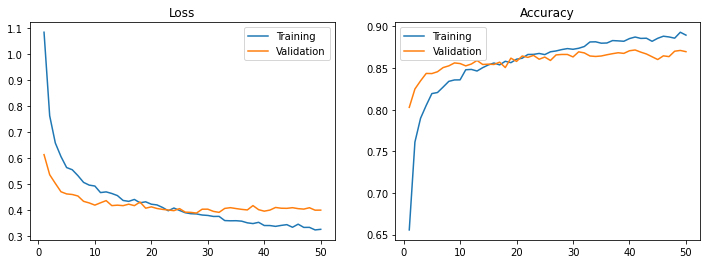

In [70]:
plot_loss_acc(tc_history, 50)